In [3]:
# make_composite_index_geo.py
import pandas as pd
import numpy as np
import json
import geopandas as gpd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

# ---------- Path configuration ----------
files = {
    "education": "/Users/ruoxin/Downloads/dissertation/edu_outputs/ghana_education.csv",
    "health": "/Users/ruoxin/Downloads/dissertation/health_outputs/ghana_health.csv",
    "publictransport": "/Users/ruoxin/Downloads/dissertation/pt_outputs/ghana_publictransport.csv",
    "shop": "/Users/ruoxin/Downloads/dissertation/shop_outputs/ghana_shop.csv",
    "green": "/Users/ruoxin/Downloads/dissertation/green_outputs/ghana_green.csv",
}

# GADM administrative units (with geometry, for exporting shapefiles)
gadm_path = "/Users/ruoxin/Downloads/gadm41_GHA_shp/gadm41_GHA_2.shp"

# Output directory and country name
out_dir = "/Users/ruoxin/Downloads/dissertation"
country = "Ghana"
os.makedirs(out_dir, exist_ok=True)


# ---------- 1) Read and merge five category indices ----------
dfs = []
for fac, path in files.items():
    df = pd.read_csv(path)
    idx_col = infer_index_col(df, fac)
    df = df[["NAME_2", idx_col]].rename(columns={idx_col: f"{fac}_index"})
    dfs.append(df.set_index("NAME_2"))

merged = pd.concat(dfs, axis=1, join="inner").reset_index()
print(merged.head())

# ---------- 2) PCA (first principal component -> composite) ----------
features = [c for c in merged.columns if c.endswith("_index")]
X = merged[features].fillna(0.0).values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=1, random_state=42)
scores = pca.fit_transform(X_scaled).flatten()

def to_0_100(arr):
    mn, mx = np.min(arr), np.max(arr)
    return (arr - mn) / (mx - mn) * 100 if mx > mn else np.zeros_like(arr)

merged["composite_index"] = to_0_100(scores)

# rank
merged["rank_composite"] = merged["composite_index"].rank(method="min", ascending=False).astype(int)

# ---------- 3) Merge back to GADM, export Shapefile + CSV ----------
gdf = gpd.read_file(gadm_path)
# Fallback: standardize the name column to NAME_2
for c in gdf.columns:
    if c.lower() in ("name_2", "name"):
        gdf = gdf.rename(columns={c: "NAME_2"})
        break
keep_cols = ["NAME_2", "geometry"]
gdf = gdf[keep_cols].merge(merged, on="NAME_2", how="left")

# Output path
out_csv  = os.path.join(out_dir, f"{country.lower()}_composite_index.csv")
out_shp  = os.path.join(out_dir, f"{country.lower()}_composite_index.shp")
out_json = os.path.join(out_dir, f"{country.lower()}_composite_pca.json")
out_top  = os.path.join(out_dir, f"{country.lower()}_composite_top5.csv")
out_bot  = os.path.join(out_dir, f"{country.lower()}_composite_bottom5.csv")

# Save CSV(without geometry)
gdf.drop(columns="geometry").to_csv(out_csv, index=False)

# Save Shapefile (ready for QGIS)
gdf.to_file(out_shp)

# Save PCA information
with open(out_json, "w", encoding="utf-8") as f:
    json.dump({
        "features": features,
        "explained_variance_ratio": float(pca.explained_variance_ratio_[0]),
        "components": dict(zip(features, pca.components_[0].tolist()))
    }, f, ensure_ascii=False, indent=2)

# Save top/bottom 5 (for easy citation in the paper)
top5 = gdf.drop(columns="geometry").nlargest(5, "composite_index")
bot5 = gdf.drop(columns="geometry").nsmallest(5, "composite_index")
top5.to_csv(out_top, index=False)
bot5.to_csv(out_bot, index=False)

合并后的数据（前5行）：
          NAME_2  education_index  health_index  publictransport_index  \
0  Asunafo North         4.244331      7.192482               1.339725   
1  Asunafo South        11.139557      4.914750               0.489786   
2  Asutifi North        12.385462      2.051307               0.386186   
3  Asutifi South        19.541809      7.418736               0.937845   
4     Tano North        16.976131      2.953999               3.275643   

   shop_index  green_index  
0    1.483155    10.665897  
1    1.268868    28.546977  
2    0.493606    19.344095  
3    4.321916    19.247587  
4    2.532548    14.421278  
✓ 已生成：
  CSV : /Users/ruoxin/Downloads/dissertation/ghana_composite_index.csv
  SHP : /Users/ruoxin/Downloads/dissertation/ghana_composite_index.shp
  PCA : /Users/ruoxin/Downloads/dissertation/ghana_composite_pca.json
  Top5: /Users/ruoxin/Downloads/dissertation/ghana_composite_top5.csv
  Bot5: /Users/ruoxin/Downloads/dissertation/ghana_composite_bottom5.csv


/var/folders/m0/tr1szknx545ddh7q4txl82940000gn/T/ipykernel_51260/2671510131.py:96: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(out_shp)
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'education_index' to 'education_'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'health_index' to 'health_ind'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'publictransport_index' to 'publictran'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'green_index' to 'green_inde'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'composite_index' to 'composite_'
  ogr_wr

In [41]:
# ghana_grdi_zonal_to_shp.py
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import os, json

# === Path configuration ===
gadm_path = "/Users/ruoxin/Downloads/gadm41_GHA_shp/gadm41_GHA_2.shp"  # Ghana L2
grdi_tif  = "/Users/ruoxin/Downloads/povmap-grdi-v1-grdiv1-geotiff/povmap-grdi-v1.tif"      # Global GRDI raster
# Optional: merge index
composite_csv = "/Users/ruoxin/Downloads/dissertation/ghana_composite_index.csv"  

out_dir = "/Users/ruoxin/Downloads/dissertation"
os.makedirs(out_dir, exist_ok=True)
out_shp = os.path.join(out_dir, "ghana_grdi_zonal.shp")
out_csv = os.path.join(out_dir, "ghana_grdi_zonal.csv")
meta_json = os.path.join(out_dir, "ghana_grdi_zonal_meta.json")

# 1) Read administrative boundaries (keep NAME_2 and geometry)
gdf = gpd.read_file(gadm_path)
for c in gdf.columns:
    if c.lower() in ("name_2","name"):
        gdf = gdf.rename(columns={c:"NAME_2"})
        break
gdf = gdf[["NAME_2","geometry"]].copy()

# 2) zonal stats(mean)
stats = zonal_stats(
    vectors=gdf,               # GeoDataFrame
    raster=grdi_tif,
    stats=["mean"],
    nodata=None,               
    all_touched=False,         
    geojson_out=False
)

# 3) Abbreviation 
gdf["GRDI_MEAN"]   = [s["mean"]   for s in stats]

# 4) merge index
if composite_csv:
    comp = pd.read_csv(composite_csv)
    gdf = gdf.merge(comp, on="NAME_2", how="left")

# 5) export
gdf.to_file(out_shp)                       # geometry, QGIS
gdf.drop(columns="geometry").to_csv(out_csv, index=False)  # For regression use

# save metadata
with open(meta_json,"w",encoding="utf-8") as f:
    json.dump({
        "gadm_path": gadm_path,
        "grdi_tif": grdi_tif,
        "join_key": "NAME_2",
        "stats": ["mean"],
        "all_touched": False,
        "nodata": None
    }, f, ensure_ascii=False, indent=2)

print("✓ Output：")
print("  SHP:", out_shp)
print("  CSV:", out_csv)
print("  META:", meta_json)

✓ 输出：
  SHP: /Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal.shp
  CSV: /Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal.csv
  META: /Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal_meta.json


/var/folders/m0/tr1szknx545ddh7q4txl82940000gn/T/ipykernel_51260/149352489.py:46: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(out_shp)                       # 带 geometry，QGIS 直接加载
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'education_index' to 'education_'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'health_index' to 'health_ind'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'publictransport_index' to 'publictran'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'green_index' to 'green_inde'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name

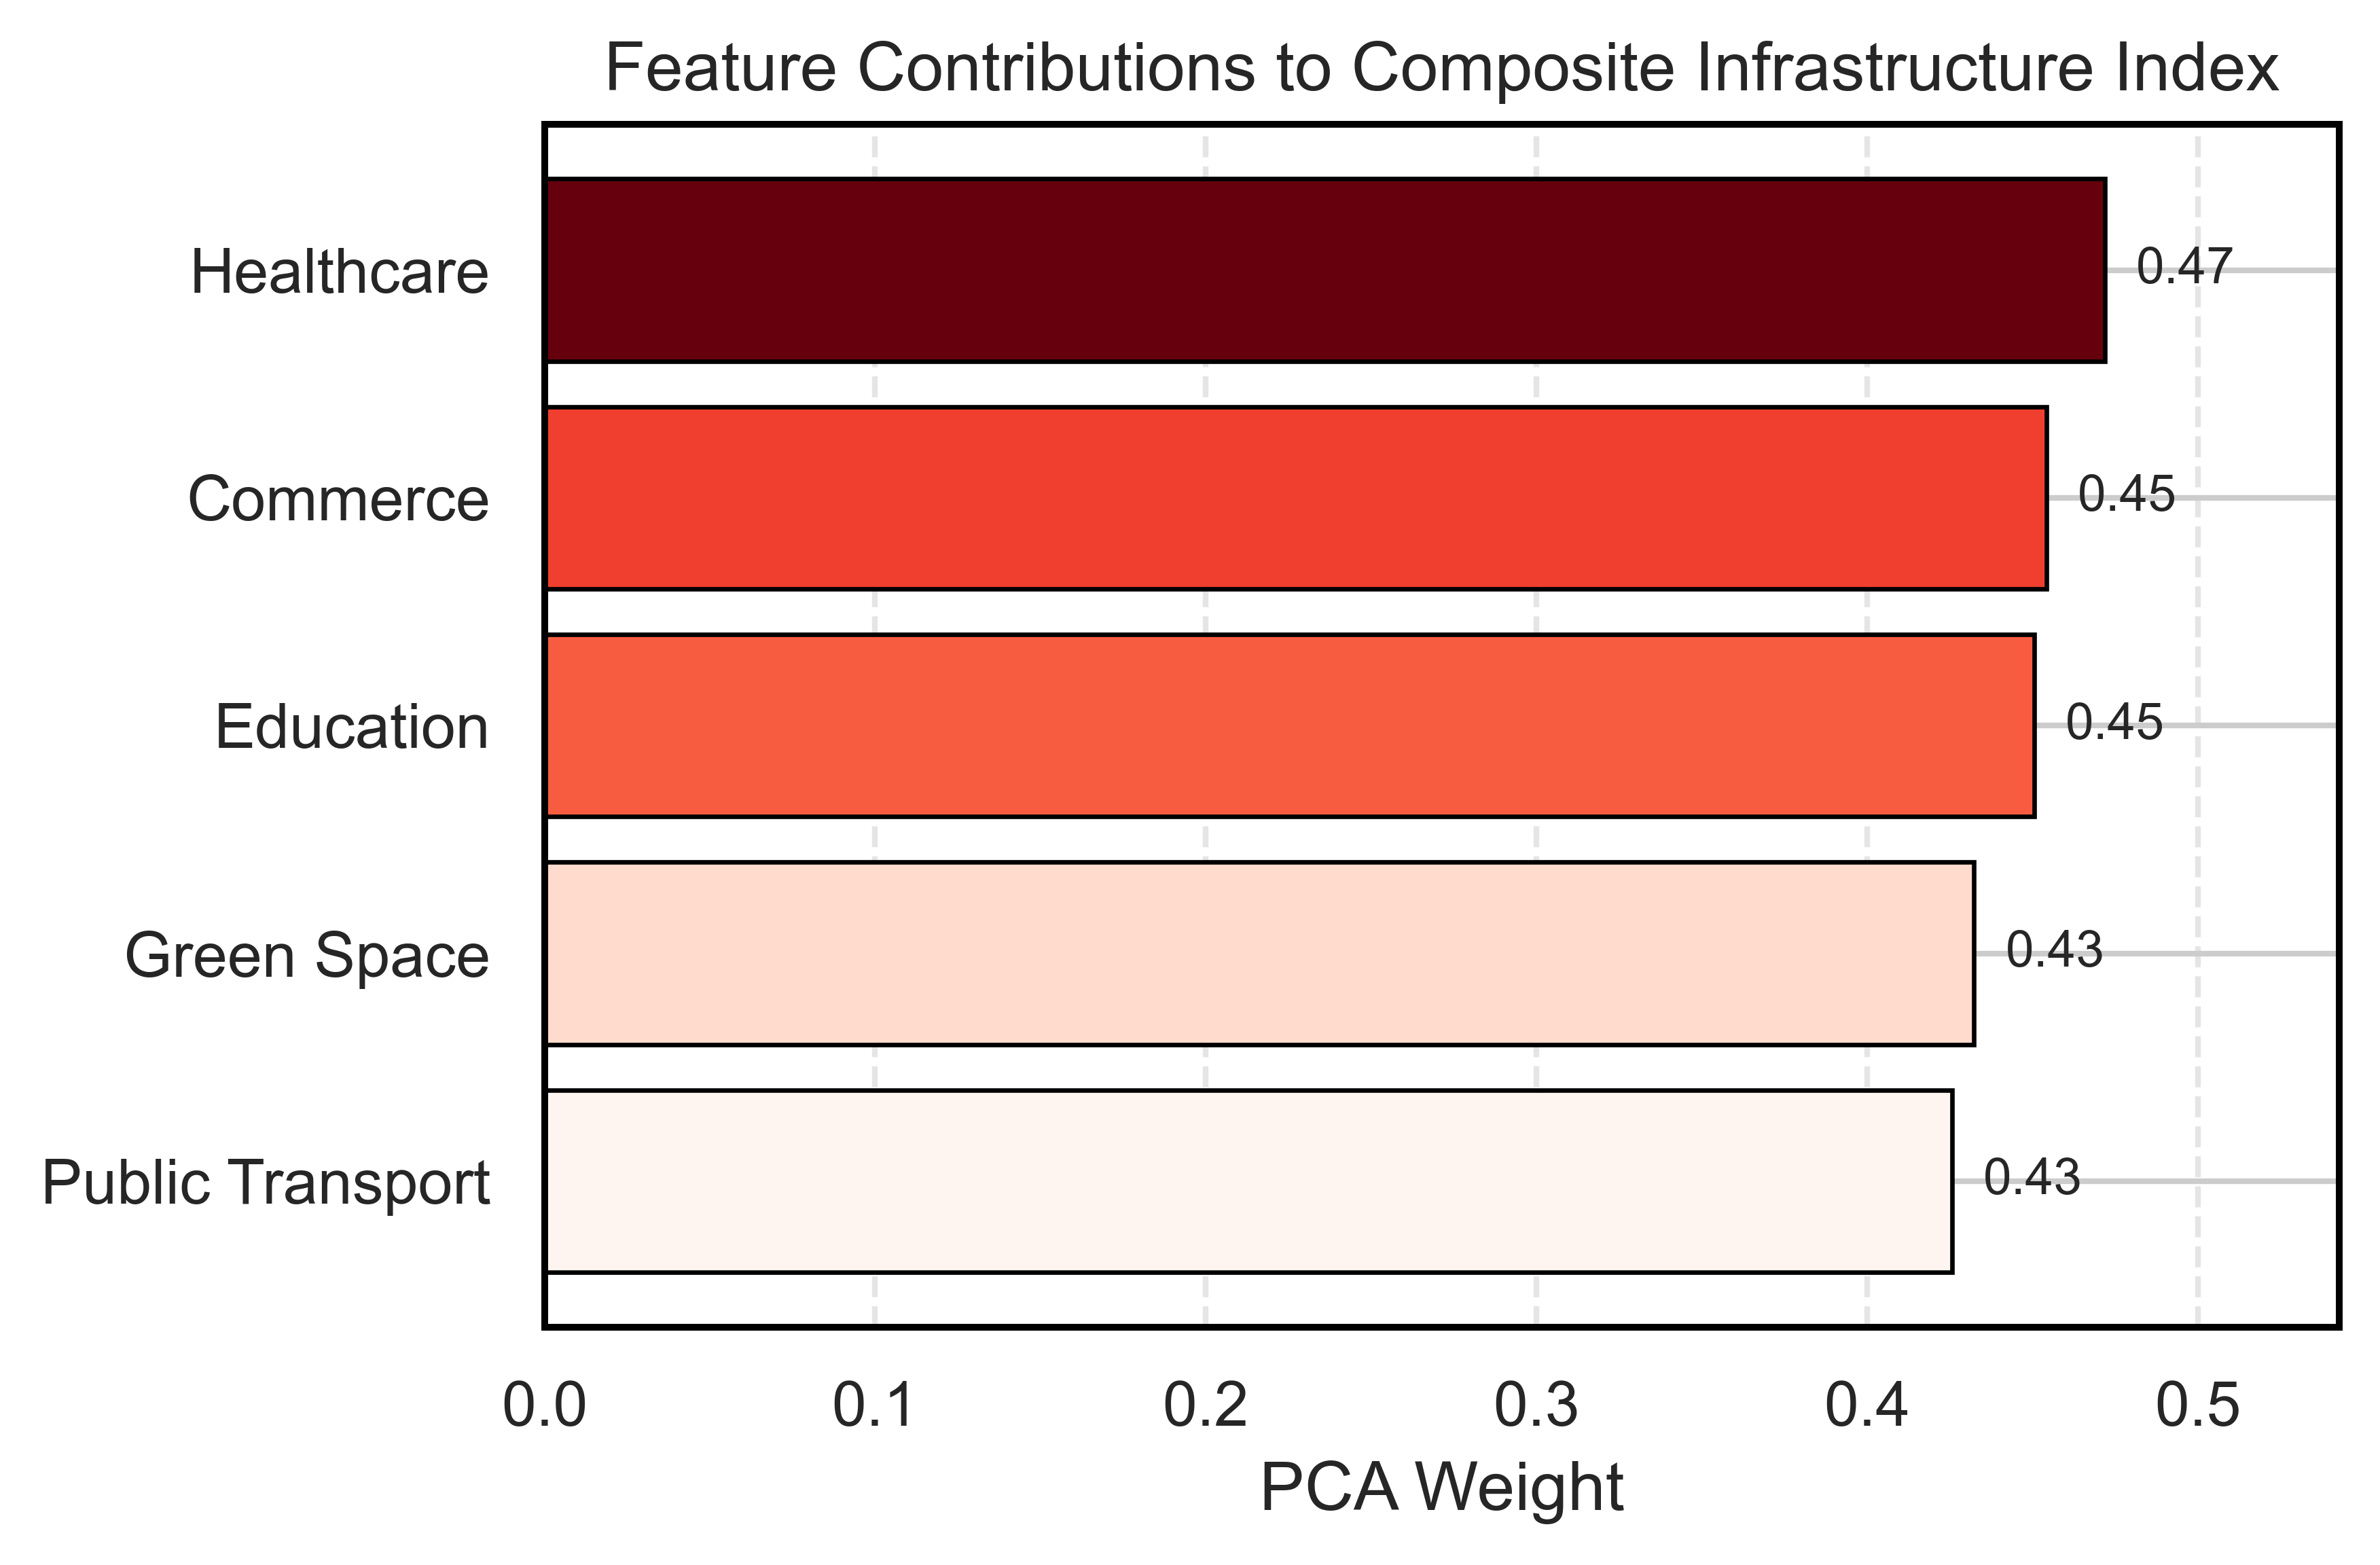

In [32]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== configuration =====
json_path = "/Users/ruoxin/Downloads/dissertation/ghana_composite_pca.json"
FIGSIZE = (6,4)
DPI = 600
SPINE_WIDTH = 1.2
SPINE_COLOR = "black"

def style_axes(ax):
    for s in ax.spines.values():
        s.set_linewidth(SPINE_WIDTH)
        s.set_edgecolor(SPINE_COLOR)

# ===== read JSON =====
with open(json_path,"r",encoding="utf-8") as f:
    data = json.load(f)
weights = data.get("components", {})

df = pd.DataFrame(list(weights.items()), columns=["feature","weight"])
df = df.sort_values("weight", ascending=True)

pretty = {
    "education_index":"Education",
    "health_index":"Healthcare",
    "commercial_index":"Commerce",
    "shop_index":"Commerce",
    "publictransport_index":"Public Transport",
    "green_index":"Green Space"
}
df["label"] = df["feature"].map(lambda x: pretty.get(x, x.replace("_"," ").title()))

# ===== Theme Colour =====
cmap = plt.cm.Reds
norm = plt.Normalize(df["weight"].min(), df["weight"].max())
colors = cmap(norm(df["weight"].values))

# ===== Paint =====
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
bars = ax.barh(df["label"], df["weight"], color=colors, edgecolor="black", linewidth=0.8)

ax.set_xlabel("PCA Weight")
ax.set_title("Feature Contributions to Composite Infrastructure Index")
ax.grid(axis="x", linestyle="--", alpha=0.5)

xmax = df["weight"].max()
ax.set_xlim(0, xmax*1.15)

for rect, w in zip(bars, df["weight"]):
    ax.text(w + xmax*0.02, rect.get_y()+rect.get_height()/2,
            f"{w:.2f}", va="center", ha="left", fontsize=9)

style_axes(ax)
plt.tight_layout()
plt.savefig("/Users/ruoxin/Downloads/dissertation/fig_pca_weights_gradient.png",
            dpi=DPI, bbox_inches="tight")
plt.show()

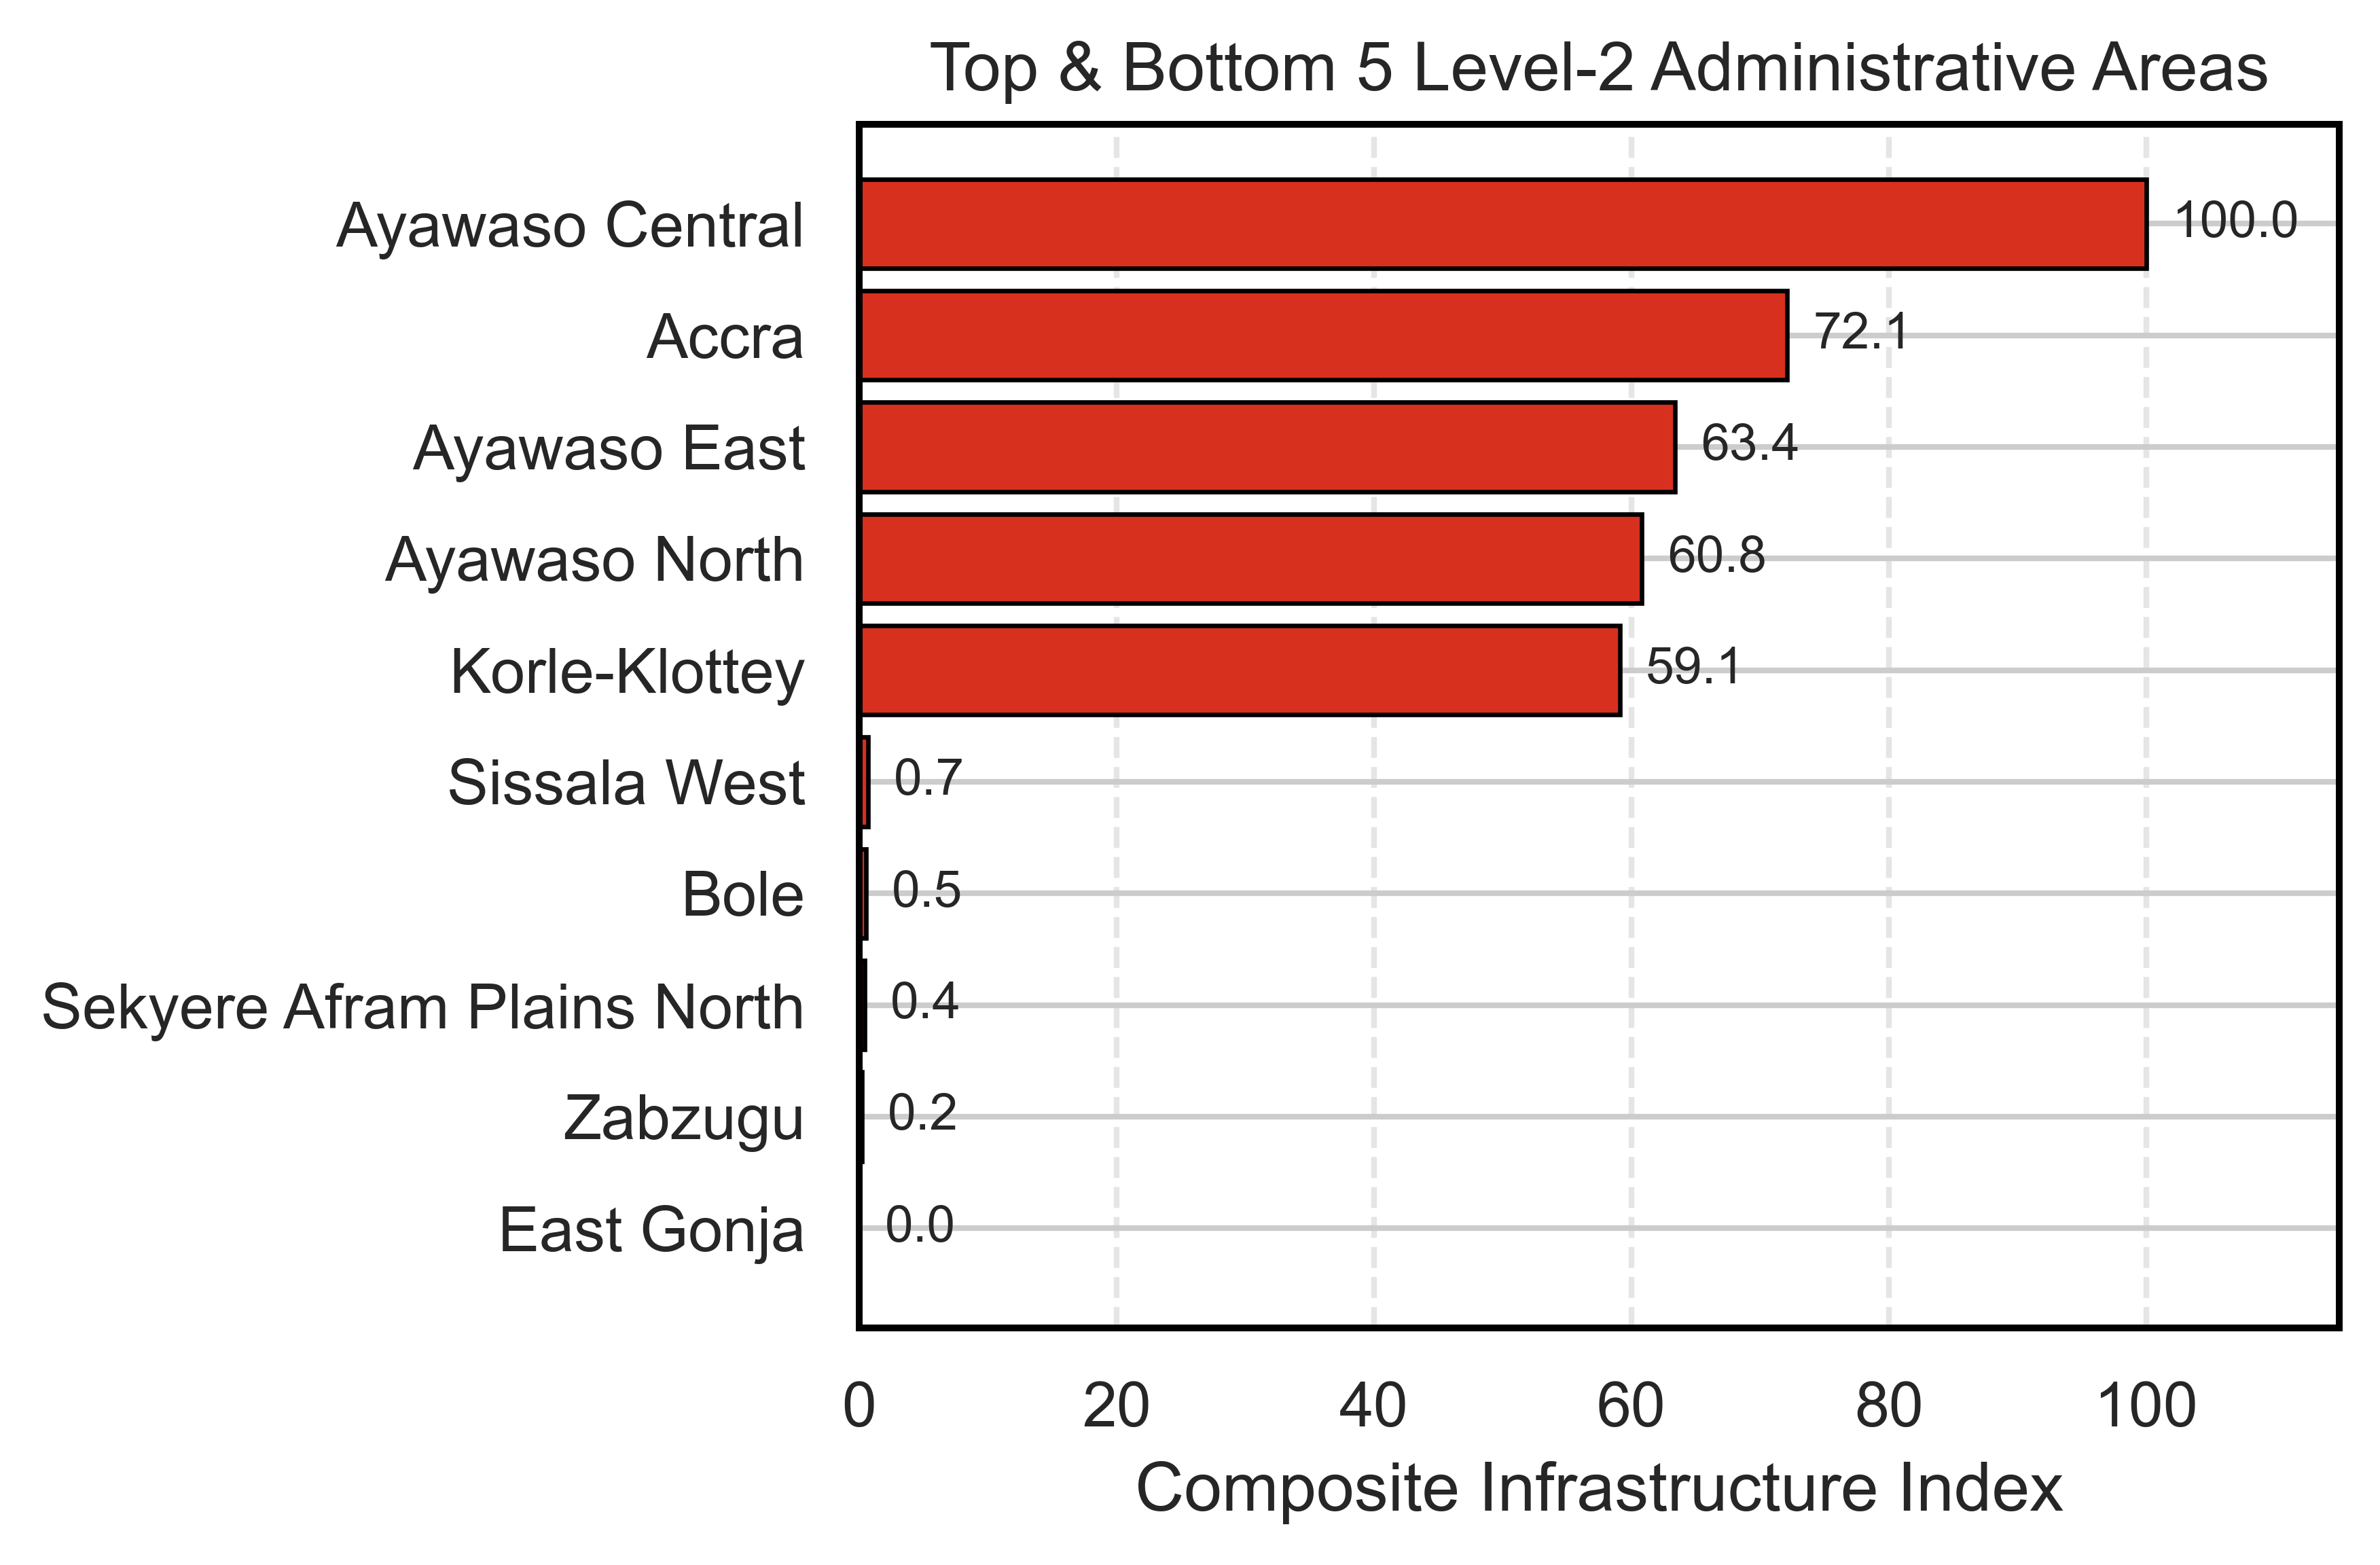

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# ===== unify =====
FIGSIZE = (6, 4)
DPI = 600
BAR_COLOR = "# d7301f" #
EDGE_COLOR = "black"
SPINE_WIDTH = 1.2
SPINE_COLOR = "black"

def style_axes(ax):
    for s in ax.spines.values():
        s.set_linewidth(SPINE_WIDTH)
        s.set_edgecolor(SPINE_COLOR)

# ===== Path =====
csv_path = "/Users/ruoxin/Downloads/dissertation/ghana_composite_index.csv"
df = pd.read_csv(csv_path)

# Top5 / Bottom5 
top5 = df.nlargest(5, "composite_index")
bot5 = df.nsmallest(5, "composite_index")
plot_df = pd.concat([bot5, top5]).sort_values("composite_index", ascending=True)

def nice_name(s, width=28):
    return textwrap.shorten(str(s), width=width, placeholder="…")

labels = plot_df["NAME_2"].map(nice_name)
values = plot_df["composite_index"].round(1)

# ===== Paint =====
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
bars = ax.barh(labels, values, color=BAR_COLOR, edgecolor=EDGE_COLOR, linewidth=0.8)

ax.set_xlabel("Composite Infrastructure Index")
ax.set_title("Top & Bottom 5 Level-2 Administrative Areas")
ax.grid(axis="x", linestyle="--", alpha=0.5)
xmax = values.max()
ax.set_xlim(0, xmax * 1.15)

# number  labelling
for rect, v in zip(bars, values):
    ax.text(v + xmax*0.02, rect.get_y() + rect.get_height()/2,
            f"{v:.1f}", va="center", ha="left", fontsize=9)

# unify
style_axes(ax)

plt.tight_layout()
plt.savefig("/Users/ruoxin/Downloads/dissertation/fig_top_bottom5.png",
            dpi=DPI, bbox_inches="tight")
plt.show()